<a href="https://colab.research.google.com/github/jiayuzhao05/jiayuzhao05/blob/main/WiDS_Workshop_Diabetes_Health_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services.

Explore some of the following research questions:

- Can survey questions from the BRFSS provide accurate predictions of whether an individual has diabetes?
- What risk factors are most predictive of diabetes risk?
- Can we use a subset of the risk factors to accurately predict whether an individual has diabetes?
- Can we create a short form of questions from the BRFSS using feature selection to accurately predict if someone might have diabetes or is at high risk of diabetes?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,precision_score,recall_score, f1_score,roc_auc_score,roc_curve,balanced_accuracy_score,confusion_matrix


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Presentations/diabetes_binary_health_indicators_BRFSS2015.csv')

# Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

0.0    86.066698
1.0    13.933302
Name: Diabetes_binary, dtype: float64


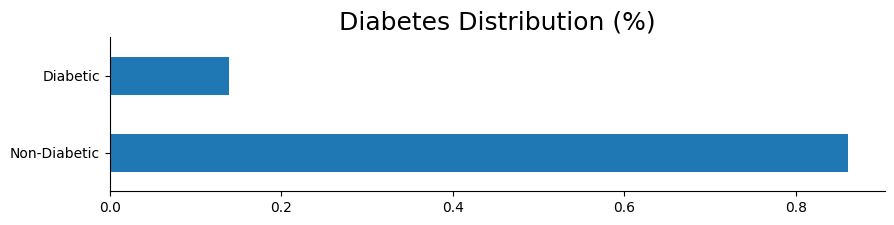

In [ ]:
#First we will look for the distribution of Diabetes in the Data
print(df['Diabetes_binary'].value_counts(normalize=True) * 100)

df['Diabetes_binary'].value_counts(1).plot(kind='barh',figsize=(10, 2)).spines[['top', 'right']].set_visible(False);
plt.title('Diabetes Distribution (%)', fontsize=18)
plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic']);

lets see the characteristics of people with or without diabetes, this will help us in shaping our data and selecting the best features. 0-Male, 1-Female

In [ ]:
#almost equal dist of sex in people with diabetes
df[df['Diabetes_binary']==1.0].Sex.value_counts(normalize=True)*100

0.0    52.087931
1.0    47.912069
Name: Sex, dtype: float64

In [ ]:
df[df['Diabetes_binary']==0.0].Sex.value_counts(normalize=True)*100

0.0    56.593568
1.0    43.406432
Name: Sex, dtype: float64

Education

This variable is a answer to Education level question:

What is the highest grade or year of school you completed?

1 = Never attended school or only kindergarten

2 = Grades 1 through 8 (Elementary)

3 = Grades 9 through 11 (Some high school)

4 = Grade 12 or GED (High school graduate)

5 = College 1 year to 3 years (Some college or technical school)

6 = College 4 years or more (College graduate)

In [ ]:
d_edu =df[df['Diabetes_binary']==1.0].Education.value_counts(normalize=True)*100 #most are college educated
d_edu

4.0    31.307644
6.0    29.423414
5.0    29.293272
3.0     6.495785
2.0     3.346913
1.0     0.132971
Name: Education, dtype: float64

In [ ]:
df[df['Diabetes_binary']==0.0].Education.value_counts(normalize=True)*100
# from this, people with diabetes are slightly less college educated overall

6.0    44.392994
5.0    27.277474
4.0    23.671989
3.0     3.289456
2.0     1.309920
1.0     0.058168
Name: Education, dtype: float64

Age

In [ ]:
age_dist = df[df['Diabetes_binary']==1.0].Age.value_counts(normalize=True)*100
age_dist

10.0    18.553726
9.0     16.219657
11.0    14.544786
8.0     12.060771
12.0     9.627681
13.0     9.078821
7.0      8.736491
6.0      4.928422
5.0      2.973462
4.0      1.771063
3.0      0.888361
2.0      0.396084
1.0      0.220676
Name: Age, dtype: float64

<ipython-input-11-1442e4810e76>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>80'], rotation = 90)


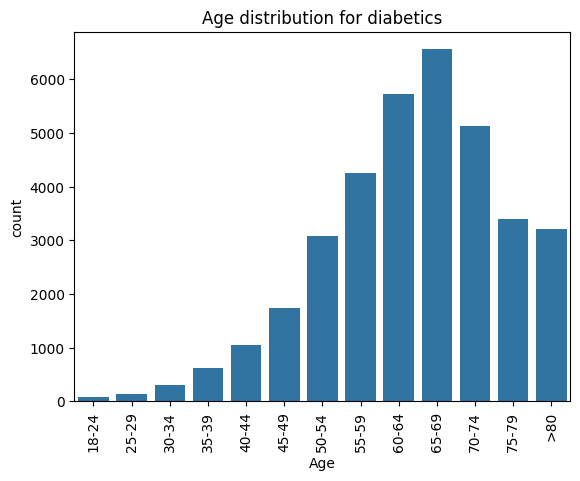

In [ ]:
# Check age distribution for people with diabetes
ax = sns.countplot(data=df[df['Diabetes_binary']==1.0], x='Age')
ax.set(title= 'Age distribution for diabetics')
ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>80'], rotation = 90)
plt.rcParams["figure.figsize"] = (15,6)

In [ ]:
# those  >=45 years old are": over 93% of all diabetic patients.
age_dist.head(8).sum()

93.75035364680585

In [ ]:
age_dist2 = df[df['Diabetes_binary']==0.0].Age.value_counts(normalize=True).to_frame() *100
age_dist2

,Age
9.0,12.600420
8.0,12.168970
10.0,11.741644
7.0,10.637830
11.0,8.423791
6.0,8.279517
5.0,6.918757
13.0,6.482728
4.0,6.044409
12.0,5.760440


In [ ]:
# compared to about 83% of those without diabetes
age_dist2[age_dist2['Age']>=6].sum()

Age    83.298066
dtype: float64

<ipython-input-15-f9ab9273c84f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>80'], rotation = 90)


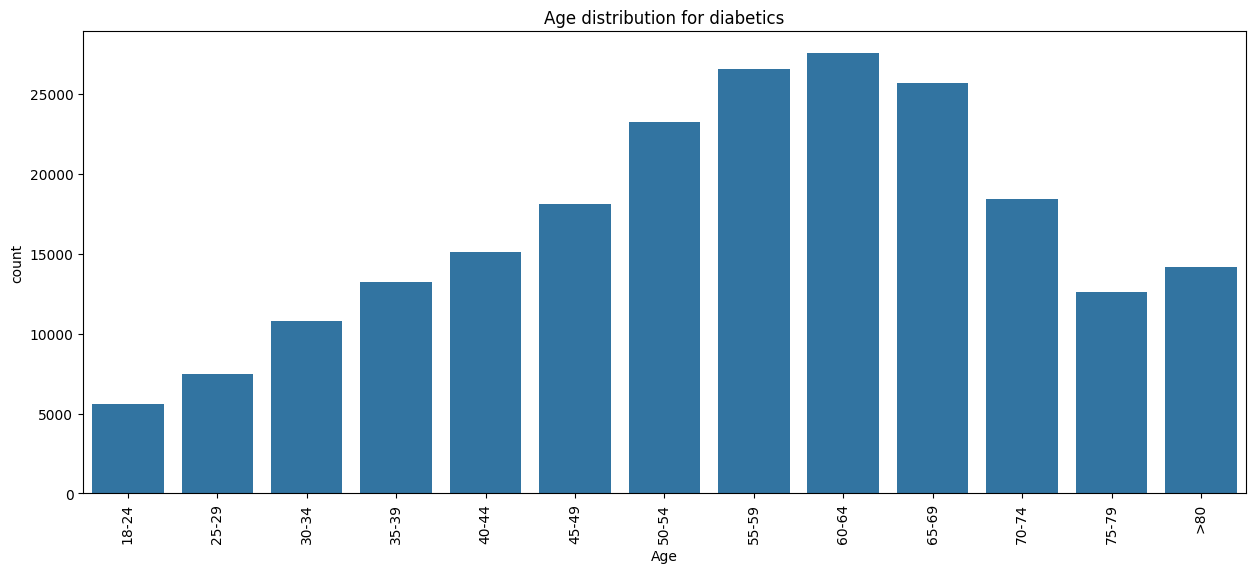

In [ ]:
# Check age distribution for people without diabetes
ax = sns.countplot(data=df[df['Diabetes_binary']==0.0], x='Age')
ax.set(title= 'Age distribution for diabetics')
ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>80'], rotation = 90)
plt.rcParams["figure.figsize"] = (15,5)

HighBP

In [ ]:
df[df['Diabetes_binary']==1.0].HighBP.value_counts(normalize=True)*100

1.0    75.267357
0.0    24.732643
Name: HighBP, dtype: float64

In [ ]:
df[df['Diabetes_binary']==0.0].HighBP.value_counts(normalize=True)*100

0.0    62.33981
1.0    37.66019
Name: HighBP, dtype: float64

incidence of highbp in diabetic patients is very high(75%), it is way lower in non-diabetic people(37%)

High Cholesterol

In [ ]:
df[df['Diabetes_binary']==1.0].HighChol.value_counts(normalize=True)*100

1.0    6.701183
0.0    3.298817
Name: HighChol, dtype: float64

In [ ]:
df[df['Diabetes_binary']==0.0].HighChol.value_counts(normalize=True)*100

0.0    61.570346
1.0    38.429654
Name: HighChol, dtype: float64

High cholesterol levels are common in diabetic patients, and much more lower in non-diabetic patients

**Heart disease or Heart attack**

In [ ]:
df[df['Diabetes_binary']==1.0].HeartDiseaseorAttack.value_counts(normalize=True)*100

0.0    77.711764
1.0    22.288236
Name: HeartDiseaseorAttack, dtype: float64

In [ ]:
df[df['Diabetes_binary']==0.0].HeartDiseaseorAttack.value_counts(normalize=True)*100

0.0    92.664908
1.0     7.335092
Name: HeartDiseaseorAttack, dtype: float64

Patients with diabetes are 3x more likely to have suffered a heart attack or gotten a heart disease.

**Stroke**

In [ ]:
# diabetic patients who have been diagnosed with stroke
df[df['Diabetes_binary']==1.0].Stroke.value_counts(normalize=True)*100

0.0    90.754258
1.0     9.245742
Name: Stroke, dtype: float64

In [ ]:
# non-diabetic patients who have been diagnosed with stroke
df[df['Diabetes_binary']==0.0].Stroke.value_counts(normalize=True)*100

0.0    96.782911
1.0     3.217089
Name: Stroke, dtype: float64

Diabetic patients are almost 3x more likely to have been diagnosed with stroke, although incidence is low in both cases.

**BMI**

According to WHO classification, a BMI less than 18.5, is considered Underweight, a BMI of 18.5-24.9 falls is Healthy, 25-29.9 falls on the Overweight Range. and a BMI of 30.0 or higher is considered obese. BMI is a major risk factor in Diabetes, people who are overweight are at an enhanced risk of especially developing type 2 Diabetes.

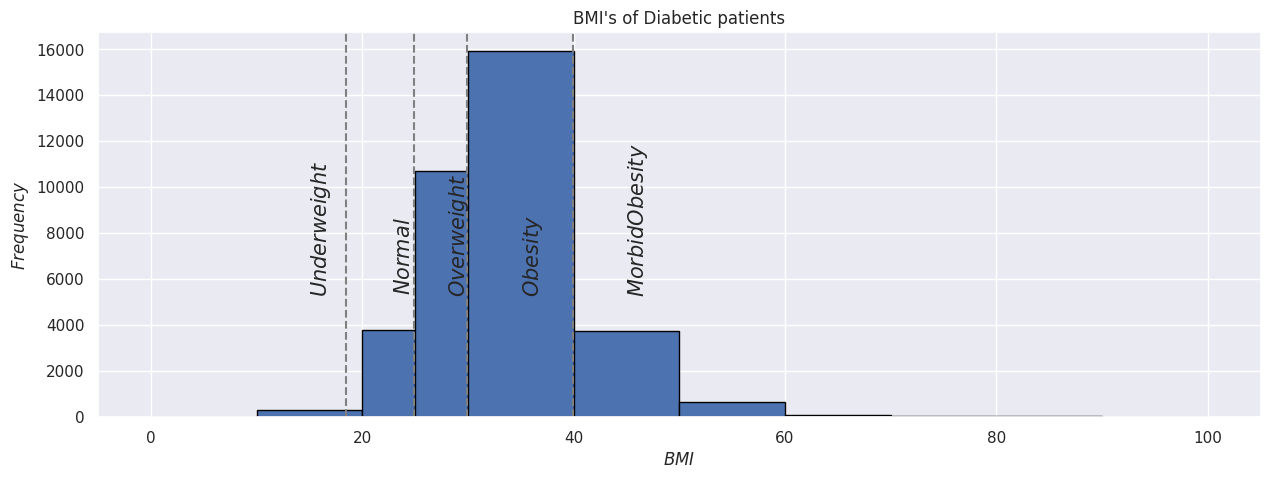

In [ ]:
plt.axvline(18.5, color='gray', linestyle='--')
plt.axvline(24.9, color='gray', linestyle='--')
plt.axvline(29.9, color='gray', linestyle='--')
plt.axvline(39.9, color='gray', linestyle='--')

# add text
plt.text(15, 5500, '$Underweight$', rotation=90, size=15)
plt.text(23, 5500, '$Normal$', rotation=90, size=15)
plt.text(28, 5500, '$Overweight$', rotation=90, size=15)
plt.text(35, 5500, '$Obesity$', rotation=90, size=15)
plt.text(45, 5500, '$Morbid Obesity$', rotation=90, size=15)

plt.hist(df[df['Diabetes_binary']==1.0].BMI,edgecolor='black', bins=[0,10,20,25,30,40,50,60,70,80,90,100])
plt.xlabel('$BMI$')
plt.ylabel('$Frequency$')
plt.title("BMI's of Diabetic patients")
plt.rcParams["figure.figsize"] = (15,5)

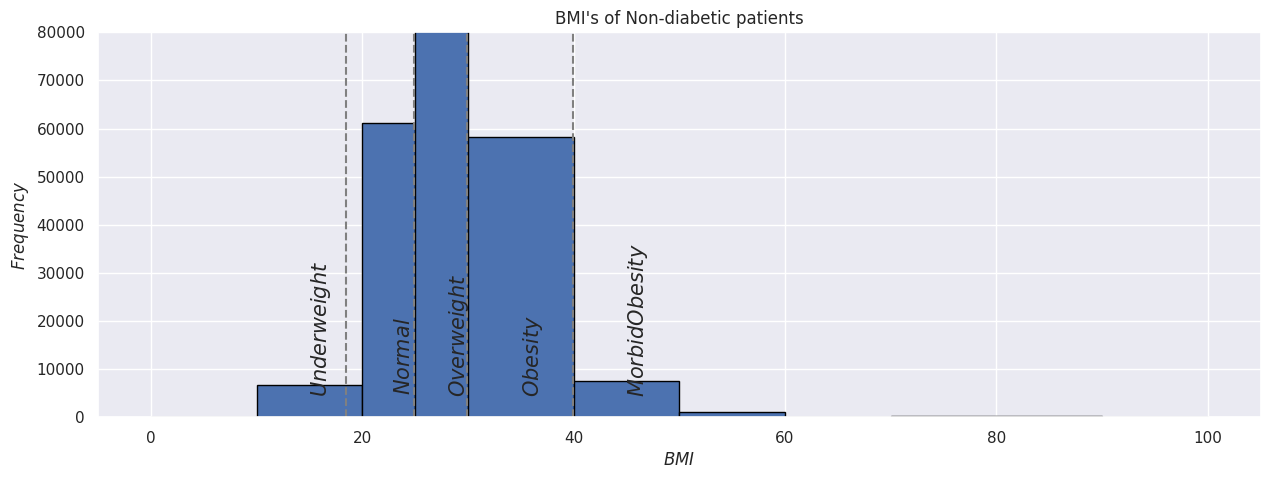

In [ ]:
plt.axvline(18.5, color='gray', linestyle='--')
plt.axvline(24.9, color='gray', linestyle='--')
plt.axvline(29.9, color='gray', linestyle='--')
plt.axvline(39.9, color='gray', linestyle='--')

# add text
plt.text(15, 5500, '$Underweight$', rotation=90, size=15)
plt.text(23, 5500, '$Normal$', rotation=90, size=15)
plt.text(28, 5500, '$Overweight$', rotation=90, size=15)
plt.text(35, 5500, '$Obesity$', rotation=90, size=15)
plt.text(45, 5500, '$Morbid Obesity$', rotation=90, size=15)

plt.hist(df[df['Diabetes_binary']==0.0].BMI,edgecolor='black', bins=[0,10,20,25,30,40,50,60,70,80,90,100])
plt.xlabel('$BMI$')
plt.ylabel('$Frequency$')
plt.ylim([0, 80000])
plt.title("BMI's of Non-diabetic patients")
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
# Hasn't fallen sick in the last 30 days and feels excellent or very good
df['PerfectHlth'] = (df['PhysHlth']==0.0) & (df['GenHlth']<3.0)
df['PerfectHlth'] = df['PerfectHlth'].astype(int)

In [ ]:
# No single issue with heart disease or BP

df['NoHrtIssue'] = (df['HighBP']==0.0) & (df['HighChol']==0.0) & (df['HeartDiseaseorAttack']==0.0)
df['NoHrtIssue'] = df['NoHrtIssue'].astype(int)

In [ ]:
# Diabetics would most likely feel unwell and in a slightly poorer state of health

df['hlthNotGood'] = df['GenHlth'] > 3
df['HlthAboveGood'] = df['GenHlth'] < 3
df['hlthNotGood'] = df['hlthNotGood'].astype(int)
df['HlthAboveGood'] = df['HlthAboveGood'].astype(int)

In [ ]:
#unwell & difficulty walking because of low or excess sugar(check to confirm)
df['hlthNotGood&DiffWalk'] = (df['GenHlth'] > 3.0) & (df['DiffWalk']==1.0)
df['hlthNotGood&DiffWalk'] = df['hlthNotGood&DiffWalk'].astype(int)

In [ ]:
# Type 2 diabetes being age-related: people with high blood pressure and heart disease/illness(more prevalent with aging)

df['hbp&HA'] = (df['HeartDiseaseorAttack'] == 1.0) & (df['HighBP'] == 1.0)
df['hbp&HA'] = df['hbp&HA'].astype(int)
df['hbp&HA'].value_counts()

0    235752
1     17928
Name: hbp&HA, dtype: int64

In [ ]:
df['older&poor'] = (df['Age'] > 5.0) & (df['Income'] < 5)
df['older&poor'] = df['older&poor'].astype(int)
df['older&poor'].value_counts()

0    206599
1     47081
Name: older&poor, dtype: int64

Plotting the correlation

Correlation of each feature to Diabetes(-ve correlation to diabetes implies +ve correlation to being non-diabetic)

In [ ]:
df_corr = df.corr(numeric_only=True)
df_corr['Diabetes_binary'].sort_values(ascending=False)

Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
hlthNotGood             0.249898
DiffWalk                0.218344
BMI                     0.216843
hlthNotGood&DiffWalk    0.211009
HighChol                0.200276
hbp&HA                  0.185759
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
older&poor              0.166253
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Education              -0.124456
Income                 -0.163919
PerfectHlth            -0.206849
NoHrtIssue             -0.234274
HlthAboveGood          -0.255507
Name: Diabetes_binary, dtype: float64

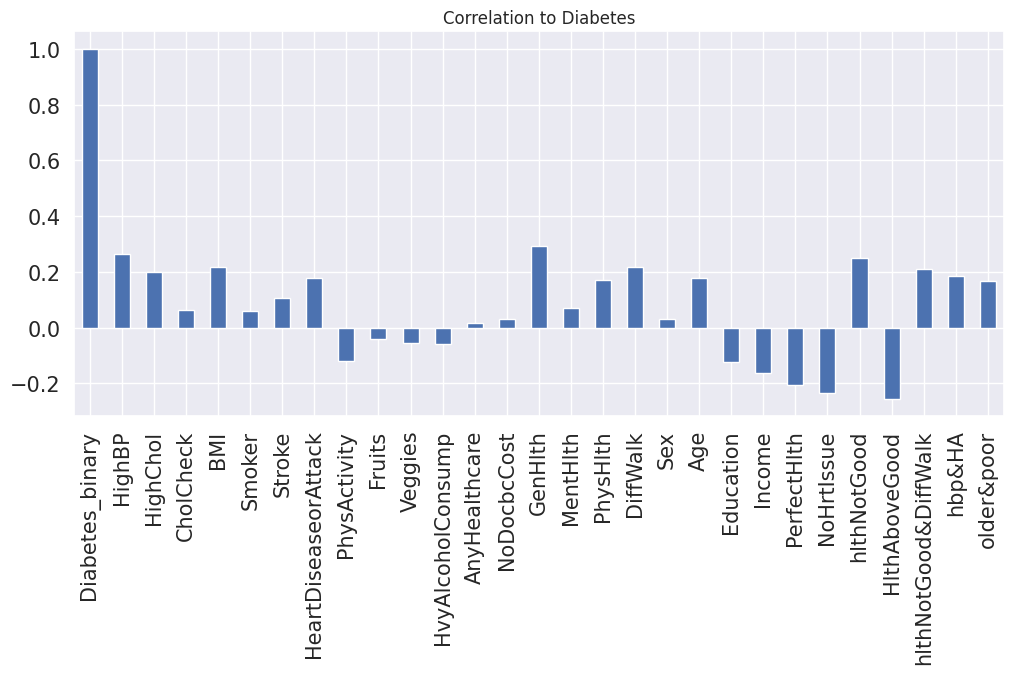

In [ ]:
sns.set(color_codes=True)
df.corrwith(df.Diabetes_binary).plot.bar( figsize = (12, 5), title = "Correlation to Diabetes", fontsize = 15, rot = 90, grid = True);

# Data Preparation


Dropping some irrelevant features

In [ ]:
df2 = df.drop(['Fruits', 'Veggies', 'AnyHealthcare', 'NoDocbcCost', 'Income',
              'Education', 'CholCheck'],axis=1)

In [ ]:
df3 = df2.copy()

In [ ]:
df3.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'PerfectHlth',
       'NoHrtIssue', 'hlthNotGood', 'HlthAboveGood', 'hlthNotGood&DiffWalk',
       'hbp&HA', 'older&poor'],
      dtype='object')

Encode categorical features

In [ ]:
cat_feats=['Diabetes_binary', 'HighBP', 'HighChol',  'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'GenHlth',  'DiffWalk', 'Sex', 'PerfectHlth', 'NoHrtIssue', 'hlthNotGood',
             'HlthAboveGood', 'hlthNotGood&DiffWalk', 'hbp&HA', 'older&poor']
lb = LabelEncoder()
for col in cat_feats:
    df3[col]=lb.fit_transform( df3[col])


In [ ]:
df3.duplicated().sum()

85170

In [ ]:
df3[df3.duplicated()]["Diabetes_binary"].value_counts()

0    82175
1     2995
Name: Diabetes_binary, dtype: int64

In [ ]:
df3.drop_duplicates()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,...,DiffWalk,Sex,Age,PerfectHlth,NoHrtIssue,hlthNotGood,HlthAboveGood,hlthNotGood&DiffWalk,hbp&HA,older&poor
0,0,1,1,1.653661,1,0,0,0,0,4,...,1,0,0.215139,0,0,1,0,1,0,1
1,0,0,0,-0.465906,1,0,0,1,0,2,...,0,0,-0.402420,0,1,0,0,0,0,1
2,0,1,1,0.146195,0,0,0,0,0,4,...,1,0,0.215139,0,0,1,0,1,0,0
3,0,1,0,-0.050254,0,0,0,1,0,1,...,0,0,0.944940,1,0,0,1,0,0,0
4,0,1,1,-0.682394,0,0,0,1,0,1,...,0,0,0.944940,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253673,0,1,0,1.824105,0,0,0,1,0,2,...,0,1,-1.467336,0,0,0,0,0,0,0
253675,0,1,1,2.052922,0,0,0,0,0,2,...,0,1,-0.913991,0,0,0,0,0,0,0
253676,1,1,1,-2.364877,0,0,0,0,0,3,...,1,0,0.944940,0,0,1,0,1,0,1
253678,0,1,0,-0.917812,0,0,0,0,0,2,...,0,1,-0.402420,0,0,0,0,0,0,1


In [ ]:
df3['Diabetes_binary'].value_counts(normalize=True).to_frame()*100

,Diabetes_binary
0,86.066698
1,13.933302


In [ ]:
X = df3.drop('Diabetes_binary', axis =1)
y = df3['Diabetes_binary']

 Using Random Oversampler to balance our target label

In [ ]:
OverS=RandomOverSampler(random_state=42, sampling_strategy='not majority')
X_over,y_over=OverS.fit_resample(X,y)

In [ ]:
X_over_train,X_over_test,y_over_train,y_over_test=train_test_split(X_over,y_over,test_size=0.2,random_state=42)

In [ ]:
X_over

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,...,DiffWalk,Sex,Age,PerfectHlth,NoHrtIssue,hlthNotGood,HlthAboveGood,hlthNotGood&DiffWalk,hbp&HA,older&poor
0,1,1,1.653661,1,0,0,0,0,4,1.468812,...,1,0,0.215139,0,0,1,0,1,0,1
1,0,0,-0.465906,1,0,0,1,0,2,-5.199338,...,0,0,-0.402420,0,1,0,0,0,0,1
2,1,1,0.146195,0,0,0,0,0,4,5.199338,...,1,0,0.215139,0,0,1,0,1,0,0
3,1,0,-0.050254,0,0,0,1,0,1,-5.199338,...,0,0,0.944940,1,0,0,1,0,0,0
4,1,1,-0.682394,0,0,0,1,0,1,0.815424,...,0,0,0.944940,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436663,1,1,0.146195,0,0,1,1,0,4,0.685567,...,1,0,-0.103160,0,0,1,0,1,1,1
436664,1,1,0.471513,1,1,1,0,0,3,5.199338,...,1,0,1.303557,0,0,1,0,1,1,1
436665,1,1,1.246925,0,1,1,0,0,1,-5.199338,...,1,0,0.569321,0,0,0,1,0,1,0
436666,1,1,0.471513,0,0,0,0,0,3,1.397296,...,1,1,-0.402420,0,0,1,0,1,0,0


# Modelling

In [ ]:
# A function that outputs our model's performance metrics
def train_evaluate_model(predictions,y_test):

    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions,average='micro')


    precision = precision_score(y_test, predictions,average='micro')
    recall = recall_score(y_test, predictions,average='micro')
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions,multi_class='ovr')

    # a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy, auc]], columns=['accuracy', 'f1_score', 'precision', 'recall', 'balanced_accuracy', 'auc'])
    return eval_df

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)
dtree = dtree.fit(X_over_train, y_over_train)
DecisionTree_over_predicted=dtree.predict(X_over_test)

In [ ]:
results = train_evaluate_model(DecisionTree_over_predicted,y_over_test)
results.index = ['Decision tree - over sampling']
results.style.background_gradient(cmap = sns.color_palette("Greens", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Decision tree - over sampling,0.890169,0.890169,0.890169,0.890169,0.890310,0.890310


In [ ]:
print('Decision Tree:')
print(classification_report(y_over_test, DecisionTree_over_predicted,
                           target_names=['non-diabetic','diabetic']))

Decision Tree:
              precision    recall  f1-score   support

non-diabetic       0.94      0.83      0.88     43773
    diabetic       0.85      0.95      0.90     43561

    accuracy                           0.89     87334
   macro avg       0.90      0.89      0.89     87334
weighted avg       0.90      0.89      0.89     87334



Recall is very important in medical domains (e.g., identifying cancer), where you really want to minimize the chance of missing positive cases (predicting false negatives). These are typically cases where missing a positive case has a much bigger cost than wrongly classifying something as positive.

The Recall score of this model is 0.95 i.e. 95% of all cases will be correctly identified. The precision is not that high at 86%, but is less problematic for the community (and the patient) than a false negative will be.

In [ ]:
# Using random forest, first lets try to figure out the best estimator
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20]
}


RF_grid_search_ = GridSearchCV(rfc, param_grid=param_grid, cv=3, n_jobs=-1,verbose=3)
RF_grid_search_.fit(X_over_train,y_over_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=3)

In [ ]:
RF_grid_search_.best_params_

{'max_depth': 20, 'n_estimators': 200}

In [ ]:
RF_grid_search_.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=200)

In [ ]:
RF_over = RandomForestClassifier(max_depth=20, n_estimators=300)
RF_over.fit(X_over_train, y_over_train)
RF_over_predctions=RF_over.predict(X_over_test)
RAndom_forst_over_score=train_evaluate_model(RF_over_predctions,y_over_test)
RAndom_forst_over_score.index = ['Random Forest - over sampling']
RAndom_forst_over_score.style.background_gradient(cmap = sns.color_palette("Greens", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Random Forest - over sampling,0.873932,0.873932,0.873932,0.873932,0.874071,0.874071


In [ ]:
print(classification_report(y_over_test, RF_over_predctions,
                           target_names=['non-diabetic','diabetic']))

              precision    recall  f1-score   support

non-diabetic       0.92      0.82      0.87     43773
    diabetic       0.84      0.93      0.88     43561

    accuracy                           0.87     87334
   macro avg       0.88      0.87      0.87     87334
weighted avg       0.88      0.87      0.87     87334



In [ ]:
# Checking on it's performance on the train set, we see that the test set performed relatively well
predr = RF_over.predict(X_over_train)
print(classification_report(y_over_train, predr,
                           target_names=['non-diabetic','diabetic']))

              precision    recall  f1-score   support

non-diabetic       0.94      0.89      0.91    174561
    diabetic       0.89      0.94      0.92    174773

    accuracy                           0.92    349334
   macro avg       0.92      0.92      0.92    349334
weighted avg       0.92      0.92      0.92    349334



In [ ]:
# Try without any params
rfc = RandomForestClassifier()
rfc.fit(X_over_train, y_over_train)
pred_test = rfc.predict(X_over_test)
print(classification_report(y_over_test, pred_test, target_names=['non-diabetic','diabetic']))

              precision    recall  f1-score   support

non-diabetic       0.95      0.85      0.90     43773
    diabetic       0.86      0.95      0.91     43561

    accuracy                           0.90     87334
   macro avg       0.91      0.90      0.90     87334
weighted avg       0.91      0.90      0.90     87334



This performs best(remember, this is predicting new data(X_over_test), not the train data. it is always important to check how your model will perform on a new set of data). RandomForest without any hyperparameters tuning performed well. with acceptable accuracy and recall

Check feature importance

In [ ]:
for name, score in zip(X_over, rfc.feature_importances_):
    print(name, score)

HighBP 0.05558058403546609
HighChol 0.028549266299326023
BMI 0.23339165313670007
Smoker 0.027645690006976597
Stroke 0.011510855765492947
HeartDiseaseorAttack 0.007759115247054833
PhysActivity 0.024428785902015422
HvyAlcoholConsump 0.010169122123294322
GenHlth 0.06473026893255655
MentHlth 0.0798894712491413
PhysHlth 0.09521028621780007
DiffWalk 0.01878275678488758
Sex 0.024686716027786628
Age 0.15672222863714758
PerfectHlth 0.021591678347473633
NoHrtIssue 0.04323544013172905
hlthNotGood 0.01320758453935397
HlthAboveGood 0.05158097585110895
hlthNotGood&DiffWalk 0.005660402008474895
hbp&HA 0.005430182307510656
older&poor 0.020236936448702645


In [ ]:
Rforst_np_over_score=train_evaluate_model(pred_test,y_over_test)
Rforst_np_over_score.index = ["Random Forest(no_hyperparam) - over sampling"]
Rforst_np_over_score.style.background_gradient(cmap = sns.color_palette("Greens", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Random Forest(no_hyperparam) - over sampling,0.900737,0.900737,0.900737,0.900737,0.900866,0.900866


XGB

In [ ]:
from xgboost import XGBClassifier
XGB_over=XGBClassifier(learning_rate=0.1)
XGB_over.fit(X_over_train,y_over_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
XGB_over_predctions=XGB_over.predict(X_over_test)
XGB_over_score=train_evaluate_model(XGB_over_predctions,y_over_test)
XGB_over_score.index=["XGB -over sampling"]
XGB_over_score.style.background_gradient(cmap = sns.color_palette("Greens", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
XGB -over sampling,0.759761,0.759761,0.759761,0.759761,0.759878,0.759878


In [ ]:
all_predictions = pd.concat([results, XGB_over_score, Rforst_np_over_score,
                    RAndom_forst_over_score],axis=0)

In [ ]:
all_predictions.drop_duplicates().style.background_gradient(cmap = sns.color_palette("Greens", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Decision tree - over sampling,0.890169,0.890169,0.890169,0.890169,0.890310,0.890310
XGB -over sampling,0.759761,0.759761,0.759761,0.759761,0.759878,0.759878
Random Forest(no_hyperparam) - over sampling,0.900737,0.900737,0.900737,0.900737,0.900866,0.900866
Random Forest - over sampling,0.873932,0.873932,0.873932,0.873932,0.874071,0.874071


Conclusion
The features that correlated with the target are: HighBP, HighChol, BMI, HlthAboveGood,hlthNotGood&DiffWalk, hbp&HA, older&poor, HeartDiseaseorAttack, PhysActivity,enHlth, PhysHlth, DiffWalk, Age

The model with best performance is the Random Forest Model with Random Overrsampling.

Our best model performance has 0.90 Accuracy with recall of 0.95 for the diabetic class

PLOT CONFUSION MATRIX OF BEST 2 MODELS

1.) RANDOM FOREST(NO HYPERPARAM)

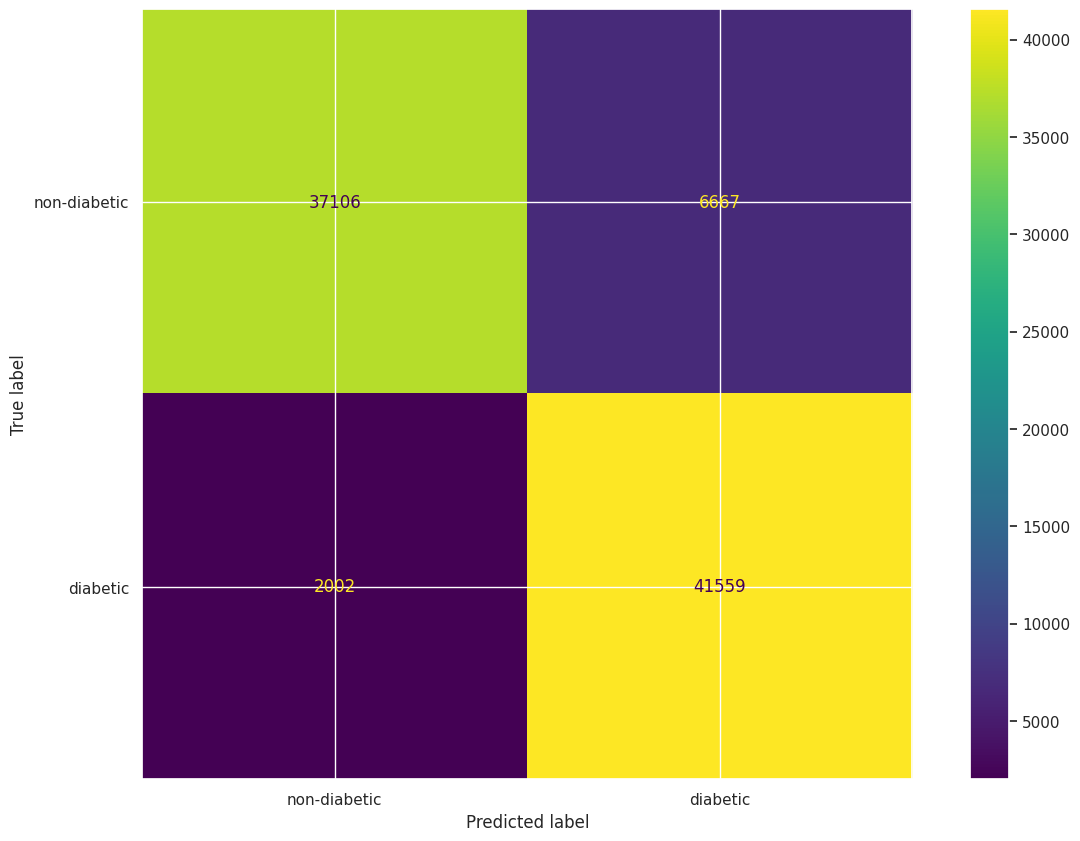

In [ ]:
cm = confusion_matrix(y_over_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-diabetic","diabetic"])
disp.plot()
plt.show()

2.) DECISION TREE

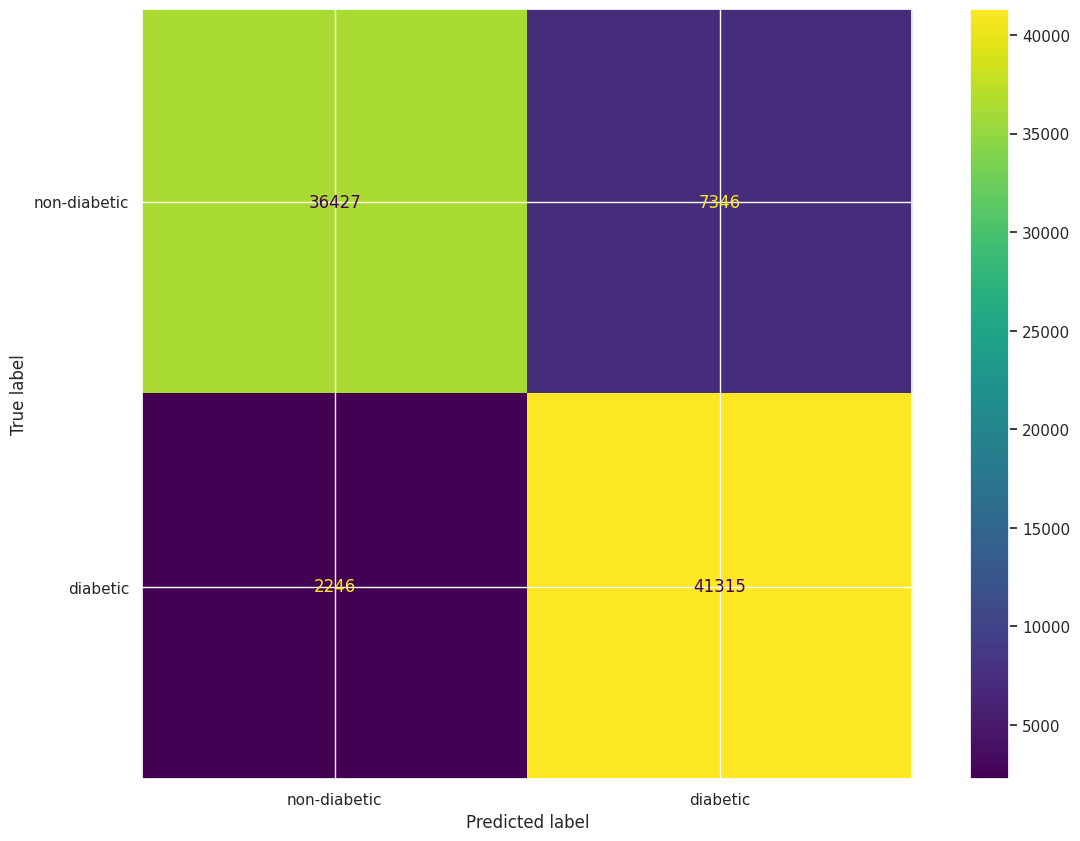

In [ ]:
cm = confusion_matrix(y_over_test, DecisionTree_over_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-diabetic","diabetic"])
disp.plot()
plt.show()